# <font style="color:rgb(50,120,229)">High Dynamic Range (HDR) Imaging  </font>
In the previous week, we learnt about contrast enhancement techniques like Histogram equalization. There are many situations where just contrast improvement is not sufficient. In this module, we will learn how to create a High Dynamic Range (HDR) image using multiple images taken with different exposure settings which is better than each one of these images.

## <font style="color:rgb(50,120,229)">What is High Dynamic Range (HDR) imaging? </font>

Most digital cameras and displays capture or display color images as 24-bits matrices. There are 8-bits per color channel and the pixel values are therefore in the range **0 – 255** for each channel. In other words, a regular camera or a display has a **limited dynamic range**.

However, the world around us has a very large dynamic range. It can get pitch black inside a garage when the lights are turned off and it can get really bright if you are looking directly at the Sun. Even without considering those extremes, in everyday situations, 8-bits are barely enough to capture the scene. So, **the camera tries to estimate the lighting and automatically sets the exposure so that the most interesting aspect of the image has good dynamic range, and the parts that are too dark and too bright are clipped off to 0 and 255 respectively**.

In the Figure below, the image on the left is a normally exposed image. Notice the sky in the background is completely washed out because the camera decided to use a setting where the subject (my son) is properly photographed, but the bright sky is washed out. The image on the right is an HDR image produced by the iPhone.


<img src="https://www.learnopencv.com/wp-content/uploads/2017/09/high-dynamic-range-hdr.jpg" width="600" height="600"/>

How does an iPhone capture an HDR image? It actually **takes 3 images at three different exposures**. The images are taken in quick succession so there is almost no movement between the three shots. **The three images are then combined to produce the HDR image**. We will see the details in the next section.

The process of combining different images of the same scene acquired under different exposure settings is called **High Dynamic Range (HDR) imaging**.

# <font style="color:rgb(50,120,229)">How to create HDR images?</font>

In this section, we will go through the steps of creating an HDR image using OpenCV. 

#### <font style="color:rgb(8,133,37)">NOTE </font>: 
All functions used in this chapter have a common structure. We first create an object for the specific algorithm class and apply the method on the list of images using the `process` method. These functions and classes can be referred [**here**](https://docs.opencv.org/4.1.0/d6/df5/group__photo__hdr.html)

## <font style="color:rgb(50,120,229)">Step 1: Capture multiple images with different exposures </font>

When we take a picture using a camera, we have only 8-bits per channel to represent the dynamic range ( brightness range ) of the scene. But **we can take multiple images of the scene at different exposures by changing the shutter speed**. Most SLR cameras have a feature called Auto Exposure Bracketing (AEB) that allows us to take multiple pictures at different exposures with just one press of a button. If you are using an iPhone, you can use this [AutoBracket HDR app](https://itunes.apple.com/us/app/autobracket-hdr/id923626339?mt=8&ign-mpt=uo%3D8) and if you are an android user you can try [A Better Camera app](https://play.google.com/store/apps/details?id=com.almalence.opencam&hl=en).

Using AEB on a camera or an auto bracketing app on the phone, we can take multiple pictures quickly one after the other so the scene does not change. When we use HDR mode in an iPhone, it takes three pictures.

1. An **underexposed** image: This image is darker than the properly exposed image. The goal is the capture parts of the image that are very bright.
2. A **properly exposed** image: This is the regular image the camera would have taken based on the illumination it has estimated.
3. An **overexposed** image: This image is brighter than the properly exposed image. The goal is the capture parts of the image that very dark and the camera needs more time to capture enough light to see what is there in the dark.

*However, if the dynamic range of the scene is very large, we can take more than three pictures to compose the HDR image.*

We will use 4 images taken with exposure time 1/30, 0.25, 2.5 and 15 seconds. The thumbnails are shown below.

<img src="https://www.learnopencv.com/wp-content/uploads/2017/10/hdr-image-sequence.jpg" />

The information about the exposure time and other settings used by an SLR camera or a Phone are usually stored in the EXIF metadata of the JPEG file. Check out this [link](https://www.howtogeek.com/289712/how-to-see-an-images-exif-data-in-windows-and-macos) to see EXIF metadata stored in a JPEG file in Windows and Mac. Alternatively, you can use my favorite command line utility for EXIF called [EXIFTOOL](https://www.sno.phy.queensu.ca/~phil/exiftool).

Let’s start by reading in the images and assigning the exposure times

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

We load the 4 images and create 2 lists:
1. `times` : contains the exposure times for the images
1. `images` : contains the images

In [3]:
def readImagesAndTimes():
  # List of exposure times
  times = np.array([ 1/30.0, 0.25, 2.5, 15.0 ], dtype=np.float32)
   
  # List of image filenames
  filenames = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]
  images = []
  for filename in filenames:
    im = cv2.imread(DATA_PATH + "images/" + filename)
    images.append(im)
   
  return images, times

In [4]:
images, times = readImagesAndTimes()

## <font style="color:rgb(50,120,229)">Step 2: Align Images </font>

Misalignment of images used in composing the HDR image can result in severe artifacts. In the Figure below, **the image on the left is an HDR image composed using unaligned images and the image on the right is one using aligned images**. By zooming into a part of the image, shown using red circles, we see severe ghosting artifacts in the left image.

<img src="https://www.learnopencv.com/wp-content/uploads/2017/10/aligned-unaligned-hdr-comparison.jpg" />

Naturally, while taking the pictures for creating an HDR image, professional photographer mount the camera on a tripod. They also use a feature called [mirror lockup](https://www.slrlounge.com/workshop/using-mirror-up-mode-mirror-lockup) to reduce additional vibrations. Even then, the images may not be perfectly aligned because there is no way to guarantee a vibration-free environment. The problem of alignment gets a lot worse when images are taken using a handheld camera or a phone.

Fortunately, OpenCV provides an easy way to align these images using **AlignMTB**. This algorithm converts all the images to **median threshold bitmaps (MTB)**. An MTB for an image is calculated by assigning the value 1 to pixels brighter than median luminance and 0 otherwise. **An MTB is invariant to the exposure time**. Therefore, the MTBs can be aligned without requiring us to specify the exposure time.

MTB based alignment is performed using the following lines of code in OpenCV.

Specifically, we create an object of AlignMTB class and apply the alignment function (`process`) on the set of images we loaded earlier.

### <font style="color:rgb(8,133,37)">Function Syntax </font>

```python
cv.AlignMTB.process(	src, dst, times, response	)
```
**Parameters**

- `src` - vector of input images ( Input )
- `dst` - vector of aligned images ( Output )


In [5]:
# Align input images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

## <font style="color:rgb(50,120,229)">Step 3: Recover the Camera Response Function </font>
    
The response of a typical camera is not linear to scene brightness. What does that mean? Suppose, two objects are photographed by a camera and one of them is twice as bright as the other in the real world. When you measure the pixel intensities of the two objects in the photograph, the pixel values of the brighter object will not be twice that of the darker object! Without estimating the Camera Response Function (CRF), we will not be able to merge the images into one HDR image.

What does it mean to merge multiple exposure images into an HDR image?

Consider just ONE pixel at some location (x,y) of the images. If the CRF was linear, the pixel value would be directly proportional to the exposure time unless the pixel is too dark ( i.e. nearly 0 ) or too bright ( i.e. nearly 255) in a particular image. We can filter out these bad pixels ( too dark or too bright ), and estimate the brightness at a pixel by dividing the pixel value by the exposure time and then averaging this brightness value across all images where the pixel is not bad ( too dark or too bright ). We can do this for all pixels and obtain a single image where all pixels are obtained by averaging “good” pixels.

But the CRF is not linear and we need to make the image intensities linear before we can merge/average them by first estimating the CRF.

The good news is that the CRF can be estimated from the images if we know the exposure times for each image. Like many problems in computer vision, the problem of finding the CRF is set up as an optimization problem where the goal is to minimize an objective function consisting of a data term and a smoothness term. These problems usually reduce to a linear least squares problem which are solved using Singular Value Decomposition (SVD) that is part of all linear algebra packages. The details of the CRF recovery algorithm are in the paper titled [Recovering High Dynamic Range Radiance Maps from Photographs](http://www.pauldebevec.com/Research/HDR/debevec-siggraph97.pdf).

Finding the CRF is done using just two lines of code in OpenCV using `CalibrateDebevec` or `CalibrateRobertson`. In this module we will use `CalibrateDebevec`.

### <font style="color:rgb(8,133,37)">Function Syntax </font>

```python
CRFObject = cv2.createCalibrateDebevec()
```


```python
dst	=	CRFObject.process(	src, times[, dst]	)
```

**Parameters**

- `src` - vector of input images
- `times` - vector of exposure time values for each image
- `dst` ( optional ) - 256x1 matrix with inverse camera response function


#### <font style = "color:rgb(8,133,37)">Exercise </font> 
Try out the Robertson method for calibration

Text(0,0.5,'Calibrated Intensity')

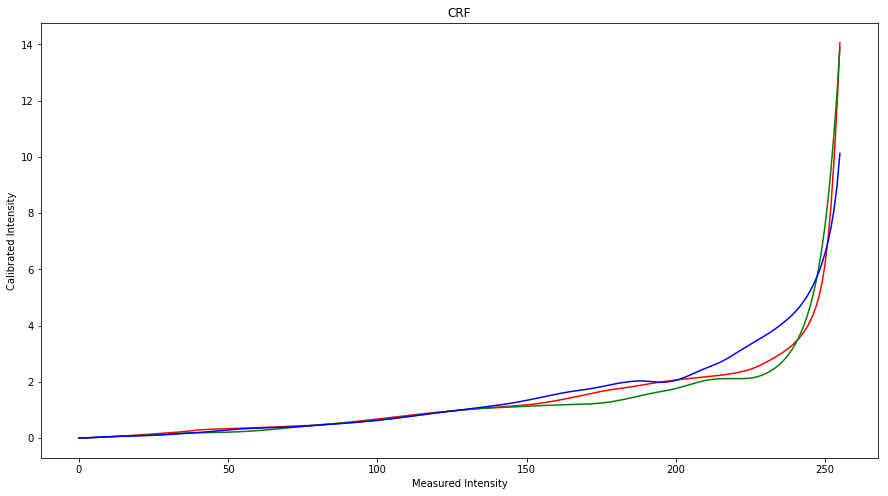

In [6]:
# Obtain Camera Response Function (CRF)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)


# Plot CRF
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

plt.figure(figsize=(15,8))
plt.plot(x, y[:,0],'r'  , x, y[:,1],'g', x, y[:,2],'b');
plt.title("CRF")
plt.xlabel("Measured Intensity")
plt.ylabel("Calibrated Intensity")

The figure above shows the CRF recovered using the images for the red, green and blue channels.

## <font style="color:rgb(50,120,229)">Step 4: Merge Images </font>

Once the CRF has been estimated, we can merge the exposure images into one HDR image using `MergeDebevec`.

In [7]:
# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)
# Save HDR image.
cv2.imwrite("hdrDebevec.hdr", hdrDebevec)


True

The HDR image saved above can be loaded in Photoshop and tonemapped. An example is shown below.



| <img src="https://www.learnopencv.com/wp-content/uploads/2017/10/hdr-Photoshop-Tonemapping-1024x770.jpg" alt="Input Image" width="600" height="600"/> |
| --- |
| <center>HDR Photoshop tone mapping
</center> |

## <font style="color:rgb(50,120,229)">Step 5: Tone mapping </font>

The process of converting a High Dynamic Range (HDR) image to an 8-bit per channel image while preserving as much detail as possible is called **Tone mapping**.

Now we have merged our exposure images into one HDR image. Can you guess the minimum and maximum pixel values for this image? The minimum value is obviously 0 for a pitch black condition. What is the theoretical maximum value? Infinite! In practice, the maximum value is different for different situations. If the scene contains a very bright light source, we will see a very large maximum value.

Even though we have recovered the relative brightness information using multiple images, we now have the challenge of saving this information as a 24-bit image for display purposes.

There are several tone mapping algorithms. OpenCV implements few of them. **The thing to keep in mind is that there is no right way to do tone mapping**. Usually, we want to see more detail in the tonemapped image than in any one of the exposure images. Sometimes the goal of tone mapping is to produce realistic images and often times the goal is to produce surreal images. The algorithms implemented in OpenCV tend to produce realistic and therefore less dramatic results.

Let’s look at the various options. Some of the common parameters of the different tone mapping algorithms are listed below.

- **`gamma`** : This parameter compresses the dynamic range by applying a gamma correction. When gamma is equal to 1, no correction is applied. A gamma of less than 1 darkens the image, while a gamma greater than 1 brightens the image.
- **`saturation`** : This parameter is used to increase or decrease the amount of saturation. When saturation is high, the colors are richer and more intense. Saturation value closer to zero, makes the colors fade away to grayscale.
- **`contrast`** : Controls the contrast ( i.e. log (maxPixelValue/minPixelValue) ) of the output image.
Let us explore the four tone mapping algorithms available in OpenCV.



### <font style="color:rgb(8,133,37)">Drago Tonemap </font>

The parameters for [Drago Tonemap](https://docs.opencv.org/4.1.0/d6/df5/group__photo__hdr.html#ga72bf92bb6b8653ee4be650ac01cf50b6) are shown below

```python
retval	=	cv.createTonemapDrago(	[, gamma[, saturation[, bias]]]	)
```
Here, bias is the value for bias function in [0, 1] range. Values from 0.7 to 0.9 usually give the best results. The default value is 0.85. For more technical details, please see this [paper](http://resources.mpi-inf.mpg.de/tmo/logmap/logmap.pdf).

The Python code is shown below. The parameters were obtained by trial and error. The final output is multiplied by 3 just because it gave the most pleasing results to me. You should play around with the parameters and see how the output changes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


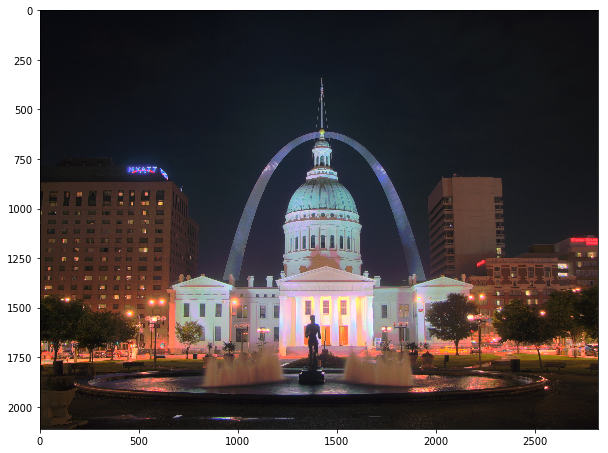

In [8]:
# Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago
plt.imshow(ldrDrago[:,:,::-1])

### <font style="color:rgb(8,133,37)">Reinhard Tonemap </font>

The parameters for [Reinhard Tonemap](https://docs.opencv.org/4.1.0/d6/df5/group__photo__hdr.html#gadabe7f6bf1fa96ad0fd644df9182c2fb) are shown below.

```python
	retval	=	cv.createTonemapReinhard(	[, gamma[, intensity[, light_adapt[, color_adapt]]]]	)
```

**parameters**

- **`intensity`** should be in the [-8, 8] range. Greater intensity value produces brighter results. 
- **`light_adapt`** controls the light adaptation and is in the [0, 1] range. A value of 1 indicates adaptation based only on pixel value and a value of 0 indicates global adaptation. An in-between value can be used for a weighted combination of the two.
- **`color_adapt`** controls chromatic adaptation and is in the [0, 1] range. The channels are treated independently if the value is set to 1 and the adaptation level is the same for every channel if the value is set to 0. An in-between value can be used for a weighted combination of the two.

For more details, check out this [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.106.8100&rep=rep1&type=pdf).

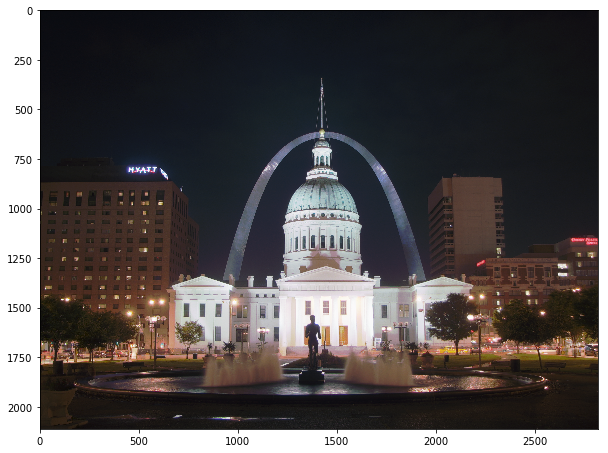

In [9]:
# Tonemap using Reinhard's method to obtain 24-bit color image
tonemapReinhard = cv2.createTonemapReinhard(1.5, 0,0,0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)
plt.imshow(ldrReinhard[:,:,::-1])

### <font style="color:rgb(8,133,37)">Mantiuk Tonemap </font>

The parameters for [Mantinuk Tonemap](https://docs.opencv.org/4.1.0/d6/df5/group__photo__hdr.html#ga3b3f3bf083b7515802f039a6a70f2d21) are shown below.

```python
	retval	=	cv.createTonemapMantiuk(	[, gamma[, scale[, saturation]]]	)
```

The parameter **scale** is the contrast scale factor. Values from 0.6 to 0.9 produce best results.

For more details, check out this [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.60.4077&rep=rep1&type=pdf).

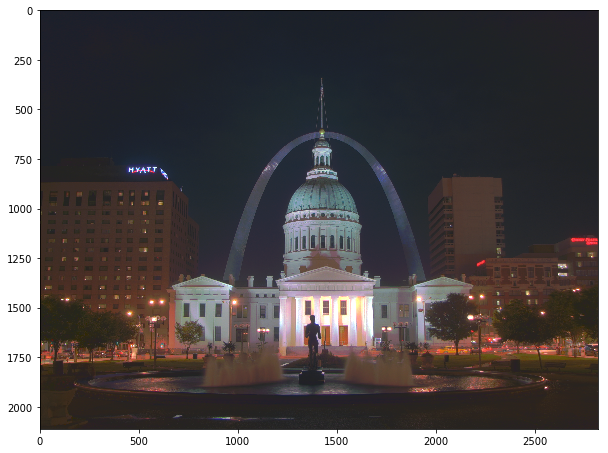

In [10]:
# Tonemap using Mantiuk's method to obtain 24-bit color image
tonemapMantiuk = cv2.createTonemapMantiuk(2.2,0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = np.clip(3 * ldrMantiuk,0,1)
plt.imshow(ldrMantiuk[:,:,::-1])

Let us compare the 3 tone-mapped outputs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2815.5, 2111.5, -0.5)

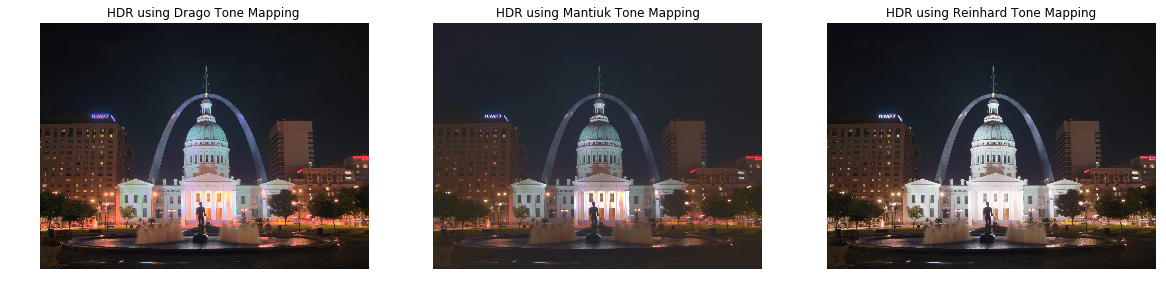

In [11]:
plt.figure(figsize=[20,10])
plt.subplot(131);plt.imshow(ldrDrago[:,:,::-1]);plt.title("HDR using Drago Tone Mapping");plt.axis('off')
plt.subplot(132);plt.imshow(ldrMantiuk[:,:,::-1]);plt.title("HDR using Mantiuk Tone Mapping");plt.axis('off')
plt.subplot(133);plt.imshow(ldrReinhard[:,:,::-1]);plt.title("HDR using Reinhard Tone Mapping");plt.axis('off')
